# Segmental Fast cross-correlation algorithm
## 1 Fast cross-correlation
The original definition of cross-correlation:

$
\hat{R_{xy}}(m) = \left\{
\begin{array}{ll}
\sum_{n = 0}^{N-m-1} x_{n+m}y_n^*, & m \geq 0 \\
\hat{R_{yx}}^*(-m), & m < 0
\end{array}
\right.
$

The calculation time of the cross-correlation function can significantly increase as the input array grows in size, when applying it according to its original definition. In practice applications, FFT-based fast cross correlation methods are commonly employed to compute cross-correlations, particularly when high-speed calculations are required.

By leveraging the Fourier transform's convolution property, the formula can be rewritten in a more concise manner, reducing the computational requirements.

$
\begin{aligned}
R_{xy}(m) & = x(n) * y(-n) \\
          & =\text{IFFT}( \text{FFT}(x(n)) \cdot \text{FFT}(y(-n))) \\
          &= \text{IFFT}(\text{FFT}(x(n)) \cdot \text{conj}(\text{FFT}(y(n))))
\end{aligned}
$

# 2 Segmental fast cross-correlation
In certain scenarios, parallelizing the algorithm can be beneficial for accelerating pattern search operations in lengthy time series data.
In this case, it's possible to divide the time series data into several segments and perform the cross correlation simultaneously.
Moreover, the results from each segment can be seamlessly combined to produce a single output that is equivalent to the original cross-correlation.

To illustrate this, let's walk through an example that demonstrates how to merge the results from each segment.

Initially, I generated a complex sequence of 38400 points, labeled as A. Then, I extracted a 256-point segment from A and designated it as B. Next, I allocated 7680 points to each segment for parallel correlation calculations.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a complex random signal
A = np.random.rand(38400) + 1j * np.random.rand(38400)
B = A[10000:10000+256]
samples_in_segment = 7680

# # debug data
# A = np.array([1, 2, 0.2, 0.1, -1, 2, 0.885, 0.657, 0.299, 0.5494, 0.1154, 0.774])
# B = np.array([1, 2])
# samples_in_segment = 6

out_len_seg = 2 * samples_in_segment - 1
# Determine the number of segments and the overlap
Nseg = np.ceil(len(A) / samples_in_segment).astype(int)
padding = Nseg * samples_in_segment - len(A)
A_padding = np.concatenate([A, np.zeros(padding, dtype=A.dtype)])
A_split = A_padding.reshape(samples_in_segment, Nseg, order='F')

Furthermore, I transformed the B sequence and each segment of A into the frequency domain using FFT. Then I applied the fast cross-relation formula to perform dot multiplication and subsequently computed partial cross-relations via IFFT.

In [2]:
import math

def fast_xcorr(A, B):
    R = max(len(A), len(B))
    out_len = 2 * R - 1
    nfft = 2 ** math.ceil(math.log2(out_len))  # base-2 fft

    A_f = np.fft.fft(A, nfft)
    B_f = np.fft.fft(B, nfft)
    res = np.fft.ifft(A_f * np.conj(B_f))
    res_sft = np.fft.fftshift(res)
    offset = (nfft - out_len) // 2 + 1
    lag = np.arange(-R+1, R)
    return res_sft[offset:offset+out_len], lag

R = []
for i in range(Nseg):  # Nseg: number of segments
    r_seg, _ = fast_xcorr(np.squeeze(A_split[:, i]), B)
    R.append(r_seg)

R = np.array(R)

Finally, I concatenated the segmental R matrix into a vector $R_{ab}$, taking care to align each column of R accordingly. Then, I compared the concatenated cross-relation with those obtained using the np. correlate function.

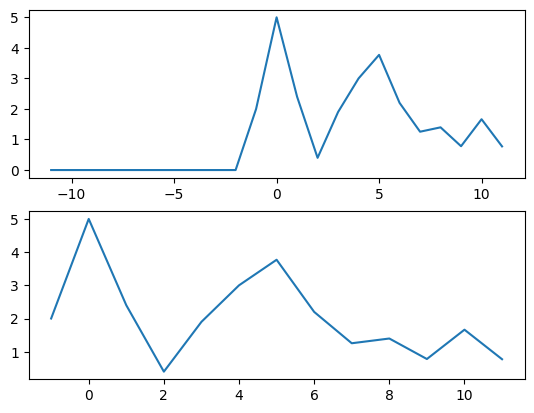

In [3]:
## concatenating segmental correlation into one.
Rab = np.zeros(A.shape[0]*2-1, dtype=R.dtype)
start = A.shape[0] - 1 - (samples_in_segment - 1)

for i in range(Nseg):
    if i != Nseg - 1:
        Rab[start:start+out_len_seg] += np.squeeze(R[i])
    else:
        Rab[start:start+out_len_seg-padding] += np.squeeze(R[i, :out_len_seg-padding])
    start += samples_in_segment

lag = np.arange(-len(A)+1, len(A))
## compare direct correlation calculation
Rab_ref = np.correlate(A, B, 'full')
l1 = np.arange(-len(B)+1, len(A))
plt.subplot(2, 1, 1)
plt.plot(lag, np.abs(Rab))
plt.subplot(2, 1, 2)
plt.plot(l1, np.abs(Rab_ref))

Now, let's us create a function to do this.

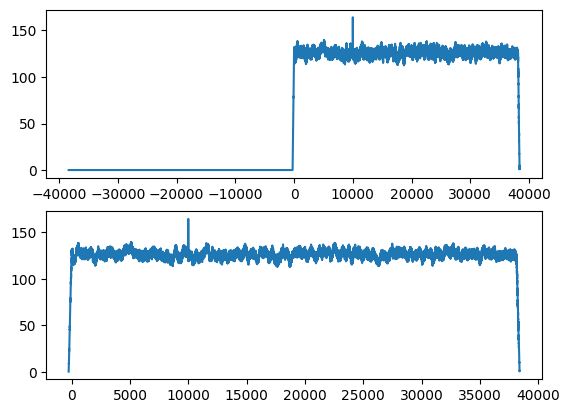

In [5]:
def fast_xcorr_segment(A, B, samples_in_segment):
    out_len_seg = 2 * samples_in_segment - 1
    ## Determine the number of segments and the padding needed
    Nseg = np.ceil(len(A) / samples_in_segment).astype(int)
    padding = Nseg * samples_in_segment - len(A)
    A_padding = np.concatenate([A, np.zeros(padding, dtype=A.dtype)])
    A_split = A_padding.reshape(samples_in_segment, Nseg, order='F')
    ## segmental xcorr
    R = []
    for i in range(Nseg):
        r_seg, _ = fast_xcorr(np.squeeze(A_split[:, i]), B)
        R.append(r_seg)
    R = np.array(R)
    ## concatenating segmental correlation into one.
    Rab = np.zeros(A.shape[0]*2-1, dtype=R.dtype)
    start = A.shape[0] - 1 - (samples_in_segment - 1)
    for i in range(Nseg):
        if i != Nseg - 1:
            Rab[start:start+out_len_seg] += np.squeeze(R[i])
        else:
            Rab[start:start+out_len_seg-padding] += np.squeeze(R[i, :out_len_seg-padding])
        start += samples_in_segment
    lag = np.arange(-len(A)+1, len(A))
    return Rab, lag

R, L = fast_xcorr_segment(A, B, samples_in_segment)

## compare direct correlation calculation
Rab_ref = np.correlate(A, B, 'full')
l1 = np.arange(-len(B)+1, len(A))
plt.subplot(2, 1, 1)
plt.plot(L, np.abs(R))
plt.subplot(2, 1, 2)
plt.plot(l1, np.abs(Rab_ref))